Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [2306]:
from random import choices, sample
import numpy as np
from collections import Counter
from copy import deepcopy, copy
from matplotlib import pyplot as plt
from scipy.stats import entropy
import lab9_lib

In [2307]:
PROBLEM_DIM = 5
N_GENERATIONS = 500
POPULATION_SIZE = 50
K_LEN = 10
N_ELITE = 3 + (POPULATION_SIZE-3)%2
N_ISLANDS = 1
MIGRATION_INTERVAL = 10
EXTINTION_INTERVAL = 6

fitness = lab9_lib.make_problem(PROBLEM_DIM)

In [2308]:

class Individual:
    def __init__(self, individual):
        self.individual = individual
        self.fitness = fitness(individual)

    def __str__(self) -> str:
        string = ""
        for i in self.individual:
            string+=str(i) 
        return string
    

    def get_fitness(self) -> str:
        return f"{self.fitness :.2%}"
    
    def equal(self, other):
        return round(self.fitness, 2) == round(other, 2)
    
    def mutation(self, probability=0.3) -> 'Individual':
        new_individual = []
        for i in self.individual:
            new_individual.append(1-i if np.random.random() <= probability else i)
        return Individual(new_individual)

    
    

In [2309]:
def two_point_crossover(individual1: Individual, individual2: Individual) -> (Individual, Individual):
    c = np.random.randint(1, K_LEN)
    d = np.random.randint(1, K_LEN)
    i1=individual1.individual
    i2=individual2.individual
    if c>d:
        c,d=d,c
    if c!=d:
        for i in range(c, d):
            i1[i], i2[i] = i2[i], i1[i]
    return Individual(i1), Individual(i2)

def uniform_crossover(individual1: Individual, individual2: Individual) -> (Individual, Individual):
    p=0.3
    i1=individual1.individual
    i2=individual2.individual
    for i in range(K_LEN):
        if np.random.random() <= p:
            i1[i], i2[i] = i2[i], i1[i]
    return Individual(i1), Individual(i2)

def crossover(individual1: Individual, individual2: Individual, flag=False):
    if flag:
        return uniform_crossover(individual1, individual2)
    else:
        return two_point_crossover(individual1, individual2)
    

In [2310]:

def tournament_selection(population, tournament_size=POPULATION_SIZE//2) -> Individual:
    tournament_participants = sample(population, tournament_size)
    winner = max(tournament_participants, key=lambda x: x.fitness)
    return winner


In [2311]:


class ISLAND:
    def __init__(self):
        self.population = sorted([Individual(choices([0, 1], k=K_LEN)) for _ in range(POPULATION_SIZE)], key=lambda x: x.fitness)
        self.hystory = []
        self.counter_extintion = 0
    
    # def compute_entropy(self): 
        
    #     concat = sum([self.population[i].individual for i in range(POPULATION_SIZE)], [])
    #     # print(concat)
    #     # print(sum(concat,[]))
        
    #     bincount=np.bincount(concat)
    #     bin_prob=bincount / K_LEN
    #     entropy = -sum([p * np.log2(p+1e-10) for p in bin_prob ])
    #     print(entropy)

    def __getitem__(self, index):
        return self.population[index]
    
    def compute_overlapping(self, vec, vec2=None):

        if vec2 is None:
            val = [ sum(bit1 == bit2 for bit1, bit2 in zip(vec, p2.individual))/K_LEN for p2 in self.population  ]
            return sum(val)/POPULATION_SIZE 
        return sum(bit1 == bit2 for bit1, bit2 in zip(vec, vec2))/K_LEN 
    
    

    def extintion(self):
        if self.counter_extintion >= EXTINTION_INTERVAL and self.counter_extintion%EXTINTION_INTERVAL==0:
            print("extintion")
           
            # print([i.fitness for i in self.population])
            count_dif = [item for item in Counter([str(i.individual) for i in self.population]).most_common() if item[1] > 2]
            
      
            
            if len(count_dif)>0:
                dup_el =[c[0] for c in count_dif]
                for m in count_dif:
                    if m[1] > 1:
                        # print(m[1])
                        same_fitness_individuals = [p for p in self.population if str(p.individual)== m[0]]
                        # print(len(same_fitness_individuals))
                        for el in same_fitness_individuals[:-1]:
                            self.population.remove(el)
                            new_el=choices([0, 1], k=K_LEN)
                            while str(new_el) in dup_el:
                                new_el=choices([0, 1], k=K_LEN)
                            self.population.append(Individual(new_el) )  
                # print(len(Counter([str(i.individual) for i in self.population]).most_common()))
               
            else:
                n_el =  min((POPULATION_SIZE//2)*self.counter_extintion//EXTINTION_INTERVAL, POPULATION_SIZE-N_ELITE)
                pop_del = sample(self.population[: (POPULATION_SIZE-N_ELITE)], n_el)

                for i in range(len(pop_del)):
                    self.population.remove(pop_del[i])
                    self.population.append(Individual(choices([0, 1], k=K_LEN)))
            self.population = sorted(self.population, key=lambda x: x.fitness)
              
         
    
    def max(self):
        return self.population[-1]
    
    def update_counter(self, max_before) ->int:
        if max_before == self.population[-1].fitness:
            self.counter_extintion +=1
        else:  
            self.counter_extintion=0
            
    

    def ga_algorithm(self):
        max_before = copy(self.population[-1].fitness)
      
        q=self.population[-N_ELITE:]
        for _ in range((POPULATION_SIZE- N_ELITE)//2):
            p1 = tournament_selection(self.population)
            p2 = tournament_selection(self.population)
            
            if self.compute_overlapping(p1.individual, p2.individual) >0.5:
                c1 = p1.mutation()
                c2 = p2.mutation()
            else:

                c1, c2 = crossover(deepcopy(p1), deepcopy(p2), )
                
            
            q.append(c1)
            q.append(c2)
        

        self.population = sorted(q, key=lambda x: x.fitness)

        
        self.update_counter(max_before)   
           
    
    def migrate(self, index, pop, index2=None):
        
        if index2 is None:
            self.population[index] = pop[POPULATION_SIZE//2 + index]
            return POPULATION_SIZE//2 + index
        self.population[index] = pop[index2]
    
   

In [2312]:

pop = [ISLAND() for _ in range(N_ISLANDS)]


best_individual = max([p.max().fitness for p in pop])

counter_migration = 0


hystory_best = []


for n in range(N_GENERATIONS):

    for i in range(N_ISLANDS): 
        # print("different",len(Counter([str(i.individual) for i in pop[0]]).most_common())) 
        # print(Counter([i.fitness for i in pop[0]]).most_common())

        pop[i].extintion()
        pop[i].ga_algorithm()
        pop[i].hystory.append(pop[i].max().fitness)
    counter_migration+=1

    best_individual = max([p.max() for p in pop], key=lambda x: x.fitness)
    hystory_best.append(best_individual.fitness)

    # if counter_migration == MIGRATION_INTERVAL:
    #     print("migrate")
    #     for i in range(N_ISLANDS):
            
    #         for j in range(10):
    #             # if np.random.random()<0.3:
    #             #     index = pop[i].migrate(j,pop[N_ISLANDS-i -1])
    #             #     pop[N_ISLANDS-i -1].migrate(index, pop[i], j)
    #             # else:
    #             pop[i].migrate(j,pop[N_ISLANDS-i -1], POPULATION_SIZE-j-1)
    #             pop[N_ISLANDS-i -1].migrate(POPULATION_SIZE-j-1, pop[i], j)


    #     counter_migration = 0 

    print(f"gen{n}: {best_individual.get_fitness()}")
    if best_individual.fitness == 1:
        break


-232.3799446471484
gen0: 80.00%
-234.8951356855792
gen1: 80.00%
-235.40073183739867
gen2: 80.00%
-234.8951356855792
gen3: 80.00%
-234.7366068897659
gen4: 80.00%
-234.01797238074585
gen5: 100.00%


ValueError: x and y must have same first dimension, but have shapes (500,) and (6,)

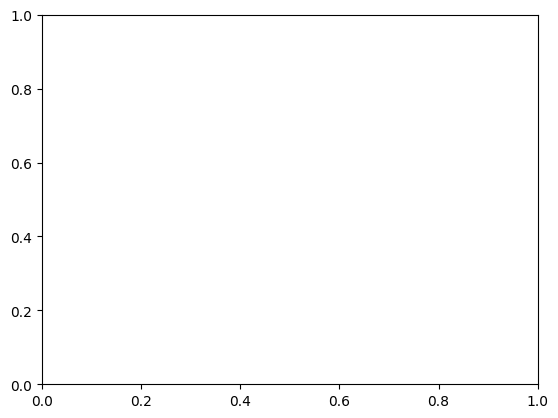

In [2313]:
x=[n for n in range(N_GENERATIONS)]
plt.figure()
str_legends = []
for i in range(N_ISLANDS):
    str_legends.append(f"island {i+1}")
    plt.plot(x,pop[i].hystory, marker=".")
plt.legend(str_legends)


plt.figure()
plt.plot(x,hystory_best, marker=".")


popolazione = 50
n_isole = 5
generaioni = 25929
problem_dim = 1
fitness_call = 7852335
RISOLTO!


popolazione = 1000
n_isole = 5
generazioni = 
problem_dim = 1
fitness_call =


In [ ]:
print(fitness.calls)

3
